In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install --quiet torch torchvision torchaudio soundfile librosa

In [9]:
!pip install --quiet transformers

In [20]:
!apt-get update -qq

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [21]:
!apt-get install -y espeak-ng

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  espeak-ng-data libespeak-ng1 libpcaudio0 libsonic0
The following NEW packages will be installed:
  espeak-ng espeak-ng-data libespeak-ng1 libpcaudio0 libsonic0
0 upgraded, 5 newly installed, 0 to remove and 31 not upgraded.
Need to get 4,526 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpcaudio0 amd64 1.1-6build2 [8,956 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsonic0 amd64 0.2.0-11build1 [10.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 espeak-ng-data amd64 1.50+dfsg-10ubuntu0.1 [3,956 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libespeak-ng1 amd64 1.50+dfsg-10ubuntu0.1 [207 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 espeak-ng amd64 1.50+dfsg-1

In [22]:
!pip install --quiet phonemizer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.4/213.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.2/587.2 kB 32.0 MB/s eta 0:00:00


In [29]:
!pip install --quiet nltk


In [30]:
import nltk
nltk.download("cmudict")


[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


True

In [7]:
# 1
import librosa
import torch

audio_path = "/content/drive/My Drive/SpeechProcessing/LJ050-0274.wav"

# Load audio using librosa
waveform_np, sample_rate = librosa.load(audio_path, sr=None, mono=True)

# Convert to torch tensor (shape: [1, samples])
waveform = torch.tensor(waveform_np).unsqueeze(0)

print("Waveform shape:", waveform.shape)
print("Sample rate:", sample_rate)


Waveform shape: torch.Size([1, 99229])
Sample rate: 22050


In [24]:
# 2
import librosa
import torch

target_sr = 16000
waveform_np = librosa.resample(
    waveform_np,
    orig_sr=sample_rate,
    target_sr=target_sr
)

waveform = torch.tensor(waveform_np)

print("Audio loaded")
print("Waveform shape:", waveform.shape)
print("Sample rate:", target_sr)

Audio loaded
Waveform shape: torch.Size([72003])
Sample rate: 16000


In [35]:
# 3
# --------------------------------------------------
# Question 3: Phoneme Recognition using Wav2Vec2
# (ARPAbet format, matching lab example)
# --------------------------------------------------

import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import nltk
from nltk.corpus import cmudict

# -------------------------------
# Load CMU Pronouncing Dictionary
# -------------------------------
nltk.download("cmudict")
cmu = cmudict.dict()

# -------------------------------
# Load pre-trained Wav2Vec2 model
# -------------------------------
processor = Wav2Vec2Processor.from_pretrained(
    "facebook/wav2vec2-base-960h"
)
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base-960h"
)

model.eval()

# -------------------------------
# Run speech recognition
# -------------------------------
inputs = processor(
    waveform.numpy(),
    sampling_rate=16000,
    return_tensors="pt",
    padding=True
)

with torch.no_grad():
    logits = model(inputs.input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)

# Decode recognized text
recognized_text = processor.batch_decode(predicted_ids)[0]

print("Recognized Text:")
print(recognized_text)

# -------------------------------
# Convert text to ARPAbet phonemes
# -------------------------------
def text_to_arpabet(text):
    phonemes = []
    for word in text.lower().split():
        if word in cmu:
            phonemes.extend(cmu[word][0])  # first pronunciation
    return phonemes

# Remove stress markers (0,1,2) from ARPAbet phonemes
arpabet_phonemes = [
    ''.join([c for c in ph if not c.isdigit()])
    for ph in arpabet_phonemes
]

print("\nRecognized Phonemes:")
print(" ".join(arpabet_phonemes))



[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Recognized Text:
MADE CERTAIN RECOMMENDATIONS WHICH IT BELIEVES WOULD IF ADOPTED

Recognized Phonemes:
M EY D S ER T AH N R EH K AH M AH N D EY SH AH N Z W IH CH IH T B IH L IY V Z W UH D IH F AH D AA P T AH D


In [36]:
# 4

# --------------------------------------------------
# Question 4: Estimate Phoneme Time Intervals
# --------------------------------------------------

# Total duration of audio (seconds)
audio_duration = waveform.shape[0] / target_sr

# Number of phonemes
num_phonemes = len(arpabet_phonemes)

# Estimated duration per phoneme
time_per_phoneme = audio_duration / num_phonemes

phoneme_intervals = []

current_time = 0.0
for ph in arpabet_phonemes:
    start_time = current_time
    end_time = current_time + time_per_phoneme
    phoneme_intervals.append((ph, start_time, end_time))
    current_time = end_time

# --------------------------------------------------
# Display estimated phoneme time intervals
# --------------------------------------------------
print("Estimated Phoneme Time Intervals:\n")

for ph, start, end in phoneme_intervals:
    print(f"{ph:>4} : {start:.3f}s → {end:.3f}s")




Estimated Phoneme Time Intervals:

   M : 0.000s → 0.102s
  EY : 0.102s → 0.205s
   D : 0.205s → 0.307s
   S : 0.307s → 0.409s
  ER : 0.409s → 0.511s
   T : 0.511s → 0.614s
  AH : 0.614s → 0.716s
   N : 0.716s → 0.818s
   R : 0.818s → 0.920s
  EH : 0.920s → 1.023s
   K : 1.023s → 1.125s
  AH : 1.125s → 1.227s
   M : 1.227s → 1.330s
  AH : 1.330s → 1.432s
   N : 1.432s → 1.534s
   D : 1.534s → 1.636s
  EY : 1.636s → 1.739s
  SH : 1.739s → 1.841s
  AH : 1.841s → 1.943s
   N : 1.943s → 2.046s
   Z : 2.046s → 2.148s
   W : 2.148s → 2.250s
  IH : 2.250s → 2.352s
  CH : 2.352s → 2.455s
  IH : 2.455s → 2.557s
   T : 2.557s → 2.659s
   B : 2.659s → 2.761s
  IH : 2.761s → 2.864s
   L : 2.864s → 2.966s
  IY : 2.966s → 3.068s
   V : 3.068s → 3.171s
   Z : 3.171s → 3.273s
   W : 3.273s → 3.375s
  UH : 3.375s → 3.477s
   D : 3.477s → 3.580s
  IH : 3.580s → 3.682s
   F : 3.682s → 3.784s
  AH : 3.784s → 3.887s
   D : 3.887s → 3.989s
  AA : 3.989s → 4.091s
   P : 4.091s → 4.193s
   T : 4.193s → 4.296s

In [37]:
# 5

# Select a phoneme index to extract (example: 2nd phoneme)
phoneme_index = 1

selected_phoneme, start_time, end_time = phoneme_intervals[phoneme_index]

# Convert time to sample indices
start_sample = int(start_time * target_sr)
end_sample = int(end_time * target_sr)

# Extract phoneme waveform segment
phoneme_segment = waveform[start_sample:end_sample]

print("Extracted Phoneme:")
print("Phoneme:", selected_phoneme)
print("Start time (s):", round(start_time, 3))
print("End time (s):", round(end_time, 3))
print("Segment shape:", phoneme_segment.shape)


Extracted Phoneme:
Phoneme: EY
Start time (s): 0.102
End time (s): 0.205
Segment shape: torch.Size([1636])


Saving and visualizing phoneme segments:

Saved: phoneme_1_M.wav  (0.000s – 0.102s)


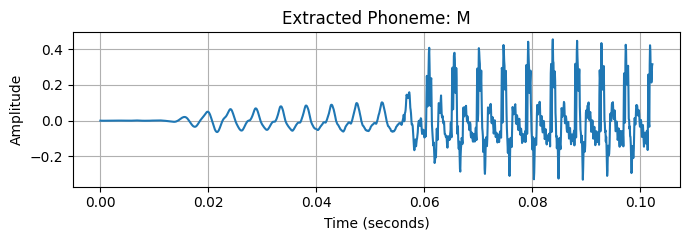

Saved: phoneme_2_EY.wav  (0.102s – 0.205s)


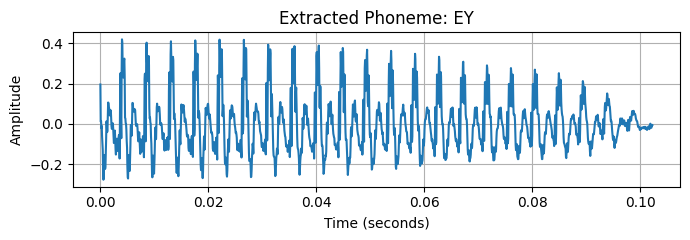

Saved: phoneme_3_D.wav  (0.205s – 0.307s)


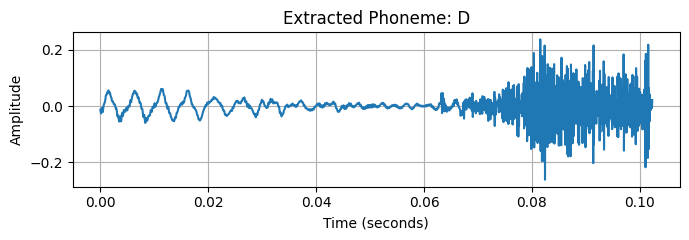

Saved: phoneme_4_S.wav  (0.307s – 0.409s)


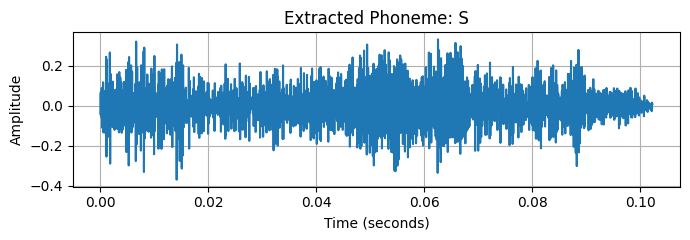

Saved: phoneme_5_ER.wav  (0.409s – 0.511s)


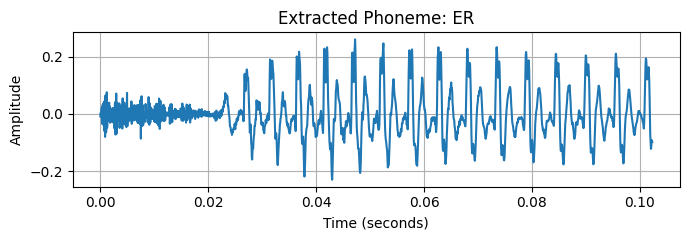

In [40]:
# 6

# --------------------------------------------------
# Question 6: Save and Visualize EACH Selected Phoneme
# --------------------------------------------------

import os
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

# Directory to save phoneme audio files
save_dir = "/content/drive/My Drive/SpeechProcessing/Lab2"
os.makedirs(save_dir, exist_ok=True)

# Number of phonemes to process (example: first 5)
num_selected_phonemes = 5

print("Saving and visualizing phoneme segments:\n")

for i in range(num_selected_phonemes):
    phoneme, start_time, end_time = phoneme_intervals[i]

    # Convert time to sample indices
    start_sample = int(start_time * target_sr)
    end_sample = int(end_time * target_sr)

    # Extract phoneme waveform
    phoneme_segment = waveform[start_sample:end_sample]

    # Save phoneme audio
    filename = f"phoneme_{i+1}_{phoneme}.wav"
    save_path = os.path.join(save_dir, filename)

    sf.write(save_path, phoneme_segment.numpy(), target_sr)

    print(f"Saved: {filename}  ({start_time:.3f}s – {end_time:.3f}s)")

    # Time axis for plotting
    time_axis = np.linspace(
        0,
        len(phoneme_segment) / target_sr,
        len(phoneme_segment)
    )

    # Plot waveform
    plt.figure(figsize=(7, 2.5))
    plt.plot(time_axis, phoneme_segment.numpy())
    plt.title(f"Extracted Phoneme: {phoneme}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


